In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
lr = 0.0001

## 이미지 데이터 불러오기

In [4]:
# 구글 드라이브를 마운트 한다.

from google import colab
colab.drive.mount("/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive/


In [0]:
import os

In [60]:
# 구글 드라이브에서 데이터가 있는 path를 찾았다.

!ls "/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/K-Data 고려대학교 빅데이터 청년인재 교육과정 1조/프로젝트/줄기"

test  train


In [0]:
data_dir = "/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/K-Data 고려대학교 빅데이터 청년인재 교육과정 1조/프로젝트/줄기"

In [69]:
# path 지정함
# os.path.join으로 path 합치는 거 해봄.

data_path = {x:os.path.join(data_dir, x) for x in ["train", "test"]}
data_path

{'test': '/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/K-Data 고려대학교 빅데이터 청년인재 교육과정 1조/프로젝트/줄기/test',
 'train': '/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/K-Data 고려대학교 빅데이터 청년인재 교육과정 1조/프로젝트/줄기/train'}

In [0]:
# Compose는 조립한다는 뜻이다.
# transforms의 함수들을 리스트로 만들어서 인자로 전달하면, pipeline같은 역할을 한다.

# data augmentation도 여기서 처리할 수 있다.
# 하지만 일단 처음 돌리는거이므로 pass.

data_transforms = transforms.Compose([
    transforms.CenterCrop(2688), # 중앙을 중심을 크롭해준다.
                                 # 인자가 int면 정방형, 가로세로 정하려면 시퀀스로.
    transforms.Resize(224),
    transforms.ToTensor(), # tensor 객체로 바꿔준다. 
    transforms.Normalize((0.5, 0.5, 0.5), (0.3, 0.3, 0.3)),# 노말라이즈한다.
                                                           # 평균과 분산을 넣는다. 채널 수 만큼 넣는다.
                                                           # 일단 아무 숫자나 넣어본다.
])

In [144]:
# ImageFolder 함수는 path에서 이미지를 load해온다. 
# ToTensor하기 전에는 PILimage로 가져온다. (이름 정확히 기억 안남)

stem_datasets = {x : torchvision.datasets.ImageFolder(data_path[x], data_transforms) \
              for x in ["train", 'test']}
stem_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 120
     Root location: /drive/My Drive/빅데이터 청년인재 고려대 과정 1조/K-Data 고려대학교 빅데이터 청년인재 교육과정 1조/프로젝트/줄기/test,
 'train': Dataset ImageFolder
     Number of datapoints: 480
     Root location: /drive/My Drive/빅데이터 청년인재 고려대 과정 1조/K-Data 고려대학교 빅데이터 청년인재 교육과정 1조/프로젝트/줄기/train}

In [145]:
# 학습하려면 DataLoader 타입으로 만들어줘야한다.

type(stem_datasets['train'])

torchvision.datasets.folder.ImageFolder

In [146]:
# 폴더 명이 class로 자동 매칭된다.

class_names = stem_datasets['train'].classes
class_names

['감수_train', '대극_train', '파극천_train']

In [147]:
dataset_sizes = {x:len(stem_datasets[x]) for x in ['train', 'test']}
dataset_sizes

{'test': 120, 'train': 480}

## train, test로 split하기
- 애초에 train, test로 나눠서 data를 불러왔으므로 필요없음

In [0]:
# local에서 폴더를 나눠놓는게 좋겠다! ㅎㅎㅎ

In [0]:
# herb_images.imgs는 이미지 데이터가 아니라 path와 라벨을 튜플로 묶어준다.
# 그래서 herb_images.imgs를 random_split하면 path를 나눠준다.
# 또한, 전체 3200개를 label 상관없이 spilt해준다. 다시말해 의미없는 짓이다.

train, test = torch.utils.data.random_split(herb_images.imgs, (3000, 200))

In [150]:
len(train)

3000

In [151]:
len(test)

200

## DataLoader 로 넘겨주기

In [152]:
# dataset을 딥러닝 학습할 데이터 셋으로 만들어 준다.... 
# batch_size를 지정할 수 있다.
# shuffle을 True로 하는게 좋다. batch돌면서 랜덤하게 데이터를 준다.
# num_workers가 0이면 모든 코어를 다 쓴다?는거 같음.

# DataLoader한 후에 train, test를 나눌 수 없다. train,test를 split한 다음에 DataLoader로 넘겨줘야한다.

dataloaders = {x: torch.utils.data.DataLoader(stem_datasets[x], batch_size=4, shuffle=True, num_workers=4) \
              for x in ['train', 'test']}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f5672753d30>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f5672753ba8>}

In [0]:
# 이건 연습용 코드
# 위와 같은 내용임.

# train = torch.utils.data.DataLoader(stem_images_train, batch_size=4, shuffle=True, num_workers=0)
# test = torch.utils.data.DataLoader(stem_images_test, batch_size=4, shuffle=False, num_workers=0)

In [154]:
# DataLoader 하기 전과 type이 바뀜.

type(dataloaders['train'])

torch.utils.data.dataloader.DataLoader

## 이미지 시각화

In [0]:
# 이미지 시각화해보기

def imshow(inp, title=None):
    """Imshow for tensor."""
    inp = inp.numpy().transpose((1,2,0))
    
    # 다음은 Normalize했던거를 되돌리는 과정인듯? 
    # 아래 step을 생략하면 이미지는 나오는데 색이 이상하게 보임.
    mean = np.array([0.5, 0.5, 0.5])
    std = ([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0 , 1)
    
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [0]:
datasets_iter = iter(dataloaders['train'])

In [0]:
# 데이터 꺼내오기

inputs, classes = next(datasets_iter)

In [0]:
# make_grid의 역할이 뭐지???

out = torchvision.utils.make_grid(inputs)

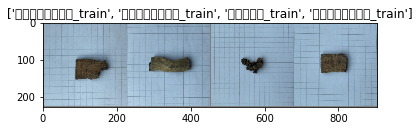

In [179]:
imshow(out, title=[class_names[x] for x in classes])

## 시행착오

In [26]:
type(herb_images.imgs)

list

In [34]:
train.dataset

[('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/001.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/002.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/003.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/004.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/005.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/006.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/007.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/008.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/009.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/010.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/011.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고

In [36]:
# 이미지가 tensor형태로 되어 있어야한다.

next(iter(herb_images))

(tensor([[[ 0.0065, -0.1373,  0.1895,  ..., -0.3987, -0.2549, -0.2941],
          [ 0.2810,  0.1111,  0.3072,  ..., -0.3333, -0.1765, -0.1895],
          [ 0.0850,  0.0065,  0.1634,  ..., -0.2680, -0.1373, -0.0980],
          ...,
          [ 0.5948,  0.5817,  0.5948,  ...,  0.0980,  0.0980,  0.0850],
          [ 0.6078,  0.6078,  0.6209,  ...,  0.0719,  0.0980,  0.1373],
          [ 0.6209,  0.6209,  0.6340,  ...,  0.1111,  0.0719,  0.1111]],
 
         [[ 0.2549,  0.1111,  0.4379,  ..., -0.2418, -0.1242, -0.1634],
          [ 0.5294,  0.3595,  0.5556,  ..., -0.1765, -0.0458, -0.0588],
          [ 0.3333,  0.2549,  0.4118,  ..., -0.1111, -0.0065,  0.0327],
          ...,
          [ 0.8562,  0.8431,  0.8562,  ...,  0.3072,  0.3072,  0.2941],
          [ 0.8431,  0.8431,  0.8562,  ...,  0.2810,  0.3072,  0.3464],
          [ 0.8562,  0.8562,  0.8693,  ...,  0.3203,  0.2810,  0.3203]],
 
         [[ 0.3464,  0.2026,  0.5294,  ..., -0.0850,  0.0065, -0.0327],
          [ 0.6209,  0.4510,

In [37]:
# 이렇게 path가 나오는게 문제다. 하하하

next(iter(test))

('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/대황 (약용)/063.jpg',
 6)

In [38]:
torch.utils.data.random_split(herb_images, (3000, 200))

In [39]:
herb_images

Dataset ImageFolder
    Number of datapoints: 3200
    Root location: /drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종

In [0]:
x, y = torch.utils.data.random_split(herb_images, (3000, 200))

In [41]:
len(y)

200

In [52]:
y.dataset.imgs

[('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/001.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/002.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/003.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/004.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/005.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/006.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/007.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/008.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/009.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/010.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고려대 과정 1조/조재성 19종/감수/011.jpg',
  0),
 ('/drive/My Drive/빅데이터 청년인재 고

In [51]:
# y를 next 찍으니까 200개에서 stop iteration이 발생했다.
# split이 되기는 했다.

t = iter(y)

for i in range(1000):
    next(t)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


StopIteration: ignored

In [0]:
torch.utils.data.DataLoader(herb_images, batch_size=4, )

In [0]:
torchvision.transforms.Normalize()

## 학습

In [0]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [0]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['test']):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = torch.autograd.Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = torch.autograd.Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data.item()  #loss.data[0] 이었는데 에러나서 수정함
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [227]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("/drive/My Drive/Colab Notebooks/vgg16_bn-6c64b313.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(

In [0]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

In [0]:
use_gpu = torch.cuda.is_available()


if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [230]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 28s
Avg loss (test): 0.2821
Avg acc (test): 0.0000
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


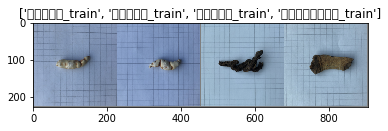

Prediction:


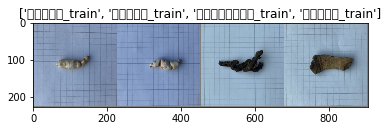

Ground truth:


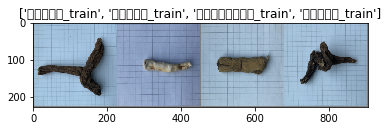

Prediction:


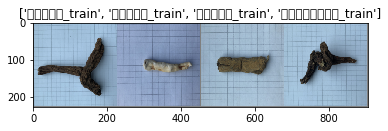

In [235]:
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

visualize_model(vgg16) #test before training

In [0]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['test']) # 원래 VAL이었음... 안만들어서 대신 test씀.
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data.item() # 수정함
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes['train']
        avg_acc = acc_train * 2 / dataset_sizes['train']
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders['test']): # 원래 VAL이었음...
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data.item() # [0]이었는데 수정함
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['test']# 원래 VAL이었음...
        avg_acc_val = acc_val / dataset_sizes['test']# 원래 VAL이었음...
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg


In [246]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina_half_dataset.pt')

Epoch 0/2
----------
Training batch 0/60.0
Validation batch 0/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Epoch 0 result: 
Avg loss (train): 0.0953
Avg acc (train): 0.0000
Avg loss (val): 0.0038
Avg acc (val): 1.0000
----------

Epoch 1/2
----------
Training batch 0/60.0
Validation batch 0/30
Epoch 1 result: 
Avg loss (train): 0.0238
Avg acc (train): 0.0000
Avg loss (val): 0.0059
Avg acc (val): 1.0000
----------


Training completed in 3m 18s
Best acc: 1.0000


In [247]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Evaluation completed in 0m 27s
Avg loss (test): 0.0038
Avg acc (test): 1.0000
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Ground truth:


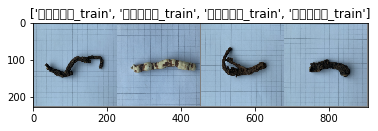

Prediction:


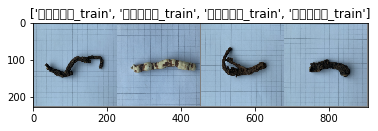

Ground truth:


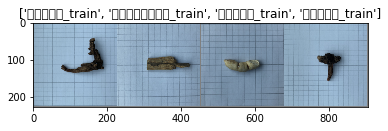

Prediction:


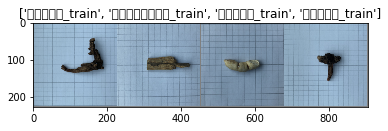

Ground truth:


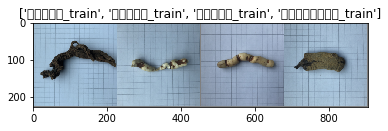

Prediction:


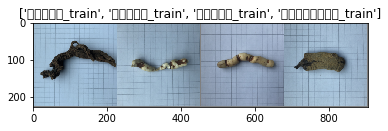

Ground truth:


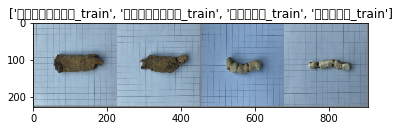

Prediction:


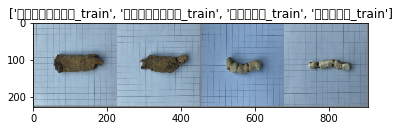

Ground truth:


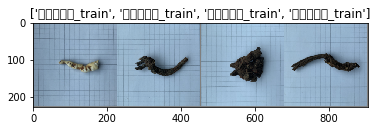

Prediction:


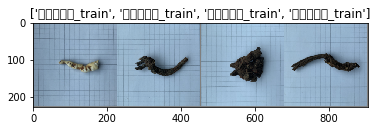

Ground truth:


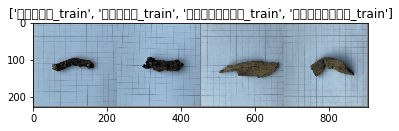

Prediction:


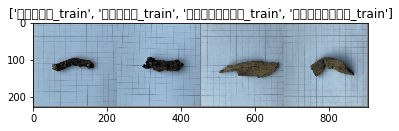

Ground truth:


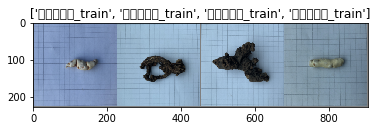

Prediction:


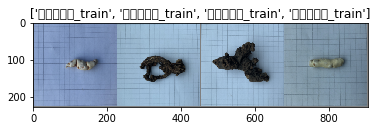

Ground truth:


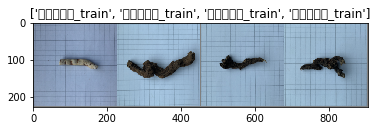

Prediction:


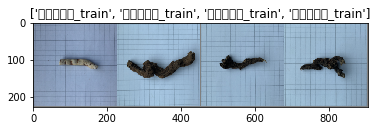

In [248]:
visualize_model(vgg16, num_images=32)
